# Test implémentation de FastText avec Pytorch

In [1]:
import sys
sys.path.append("../")
sys.path.append("../src/")

## Chargement des données

In [2]:
import pandas as pd
df_orig = pd.read_parquet("../data/extraction_sirene_20220712.parquet", engine="pyarrow")

In [3]:
distinct_values = df_orig["APE_SICORE"].unique().tolist()
y_dict = {key: value for key, value in zip(distinct_values, range(len(distinct_values)))}

In [4]:
import pandas as pd
import yaml

df = df_orig.sample(frac=0.0001, random_state=1)

In [5]:
df.shape

(1087, 20)

## Pytorch

In [6]:
from pytorch_classifier.pytorch_trainer import PytorchTrainer

# Trainer module
trainer = PytorchTrainer()

/opt/mamba/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
categorical_features = ['AUTO', 'NAT_SICORE', 'SURF', 'EVT_SICORE']

In [8]:
LEARNING_RATE = 3e-4
PATIENCE = 5
NUM_EPOCHS = 3

params = {
    "num_epochs": NUM_EPOCHS,
    "patience": PATIENCE,
    "train_proportion": 0.8,
    "batch_size": 64,
    "learning_rate": LEARNING_RATE,
    "buckets": 2000000,
    "embedding_dim": 120,
    "min_count": 3,
    "min_n": 3,
    "max_n": 4,
    "word_ngrams": 3
}

In [9]:
from pytorch_classifier.pytorch_preprocessor import PytorchPreprocessor
from src.constants import TEXT_FEATURE, Y

pytorch_preprocessor = PytorchPreprocessor()
df_train_py, df_test_py, df_gu_py = pytorch_preprocessor.preprocess(
    df=df,
    y=Y,
    text_feature=TEXT_FEATURE,
    categorical_features=categorical_features,
)

In [10]:
df_train_py.head()

,LIB_SICORE,AUTO,NAT_SICORE,SURF,EVT_SICORE,APE_NIV5
LIA_NUM,,,,,,
U69078320937,activit club sport,10,3,0,2,57
U34075388943,conseil matier immobilier,7,3,0,1,127
I94150216737,vent correspond,3,1,0,15,8
U69079330034,conseil commun,1,3,0,1,69
U35072683244,conseil bat,1,3,0,0,127


In [11]:
pytorch_classifier = trainer.train(df_train_py, Y, TEXT_FEATURE, categorical_features, params)

11it [00:10,  1.04it/s]0:00<?, ?it/s]


Moving GPU: 0.00016379356384277344
Forward: 0.6416831016540527
Backward: 1.4706690311431885
Update: 8.032469034194946


3it [00:00, 35.71it/s]
 33%|███▎      | 1/3 [00:10<00:21, 10.71s/it]

Epoch: 1 | train_loss: 7.15121, val_loss: 6.82917, lr: 3.00E-04, _patience: 5


11it [00:10,  1.09it/s]


Moving GPU: 0.0001900196075439453
Forward: 0.6613528728485107
Backward: 1.500817060470581
Update: 7.374882936477661


3it [00:00, 25.97it/s]
 67%|██████▋   | 2/3 [00:20<00:10, 10.42s/it]

Epoch: 2 | train_loss: 6.56053, val_loss: 6.42009, lr: 3.00E-04, _patience: 5


11it [00:10,  1.08it/s]


Moving GPU: 0.00023031234741210938
Forward: 0.6406075954437256
Backward: 1.5274953842163086
Update: 7.563235521316528


3it [00:00, 36.46it/s]
100%|██████████| 3/3 [00:31<00:00, 10.41s/it]


Epoch: 3 | train_loss: 6.05451, val_loss: 6.07726, lr: 3.00E-04, _patience: 5


In [12]:
from pytorch_classifier.pytorch_evaluator import PytorchEvaluator

evaluator = PytorchEvaluator(model=pytorch_classifier, tokenizer=trainer.tokenizer)

../src/pytorch_classifier/pytorch_evaluator.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


0
             ground_truth_2 ground_truth_3 ground_truth_4 ground_truth_5  \
liasseNb                                                                   
M56011948787             56            561           5610          5610C   
M60012884685             31            310           3109          3109B   
U13070128944             96            960           9609          9609Z   
M30019026881             56            561           5610          5610C   
M57021047784             56            561           5610          5610C   
...                     ...            ...            ...            ...   
G30021059293             68            682           6820          6820B   
G67029331882             68            682           6820          6820B   
U75077803418             86            869           8690          8690F   
C89020002737             47            471           4711          4711B   
M34011907510             18            181           1813          1813Z   

         

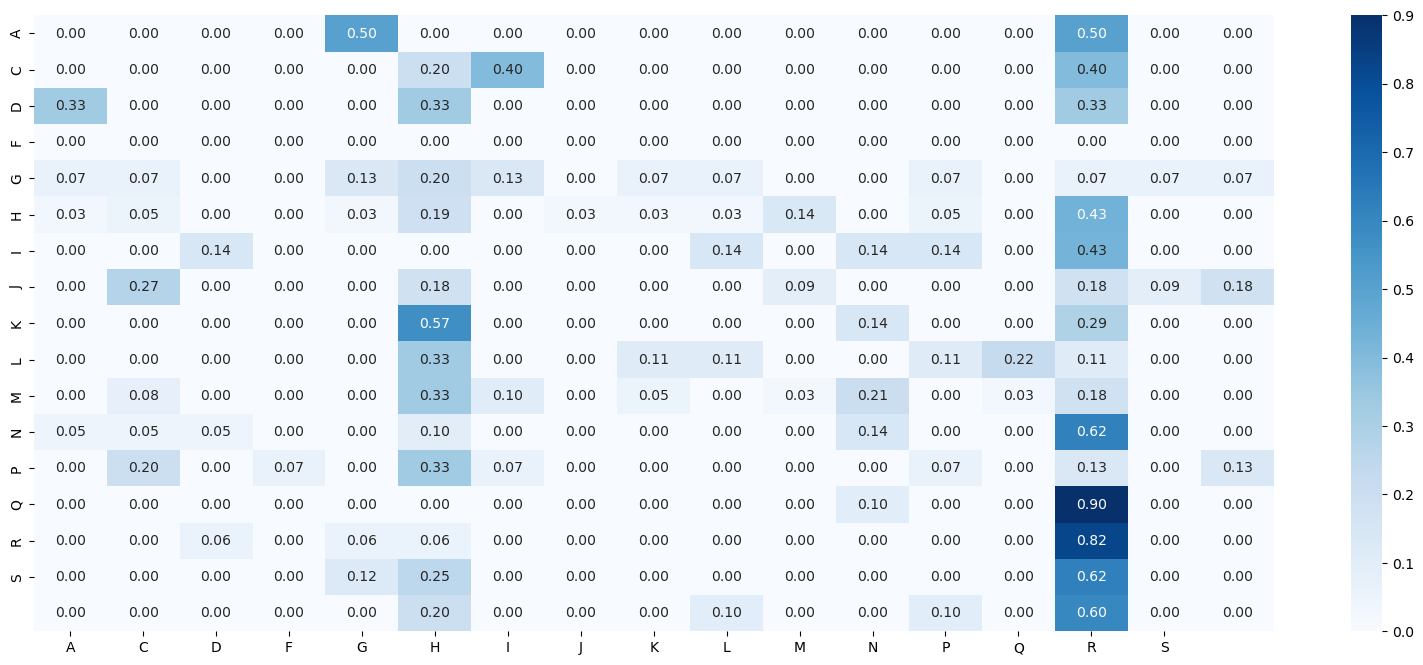

In [15]:
evaluation = evaluator.evaluate(
    df_test_py, Y, TEXT_FEATURE, categorical_features, 5
)

In [16]:
evaluation

({'accuracy_level_1': 0.13302752293577982,
  'accuracy_level_2': 0.10550458715596331,
  'accuracy_level_3': 0.06880733944954129,
  'accuracy_level_4': 0.05963302752293578,
  'accuracy_level_5': 0.027522935779816515,
  'accuracy_level_1_proba_0.05': 0.17889908256880735,
  'accuracy_level_2_proba_0.05': 0.1559633027522936,
  'accuracy_level_3_proba_0.05': 0.11926605504587157,
  'accuracy_level_4_proba_0.05': 0.11009174311926606,
  'accuracy_level_5_proba_0.05': 0.0779816513761468,
  'accuracy_level_1_proba_0.1': 0.22477064220183487,
  'accuracy_level_2_proba_0.1': 0.20642201834862386,
  'accuracy_level_3_proba_0.1': 0.16972477064220184,
  'accuracy_level_4_proba_0.1': 0.16055045871559634,
  'accuracy_level_5_proba_0.1': 0.12844036697247707,
  'accuracy_level_1_proba_0.15': 0.26146788990825687,
  'accuracy_level_2_proba_0.15': 0.24311926605504589,
  'accuracy_level_3_proba_0.15': 0.21100917431192662,
  'accuracy_level_4_proba_0.15': 0.2018348623853211,
  'accuracy_level_5_proba_0.15': 0.1